In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:

import IPython.display as ipd
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from sklearn.utils import class_weight
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

/usr/local/lib/python3.7/dist-packages/resampy/interpn.py:114: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  _resample_loop_p(x, t_out, interp_win, interp_delta, num_table, scale, y)


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


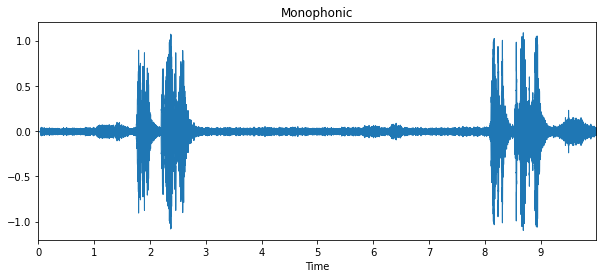

In [ ]:
SOUND_DIR = "/content/drive/MyDrive/BirdCallClassification/data/Antilophiabokermanni/Antilophiabokermanni118707.mp3"
# listen to the recording
ipd.display(ipd.Audio(SOUND_DIR))

# load the mp3 file
signal, sr = librosa.load(SOUND_DIR, duration=10)  # sr = sampling rate

# plot recording signal
plt.figure(figsize=(10, 4))
librosa.display.waveplot(signal, sr=sr)
plt.title("Monophonic")
plt.show()

In [ ]:
%cd /content/drive/MyDrive/BirdCallClassification/models

/content/drive/MyDrive/BirdCallClassification/models


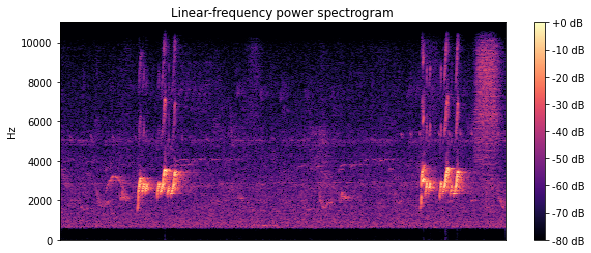

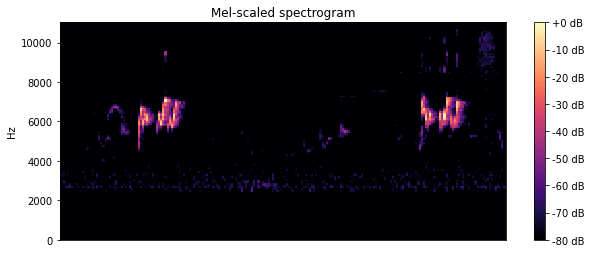

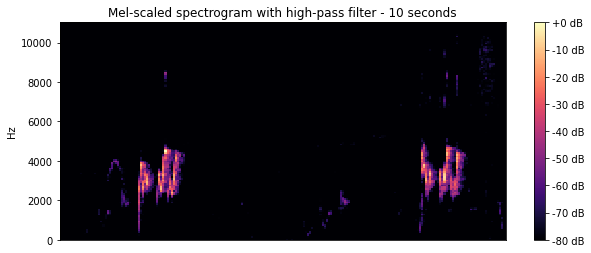

In [ ]:
# Plot spectogram
plt.figure(figsize=(10, 4))
D = librosa.amplitude_to_db(np.abs(librosa.stft(signal)), ref=np.max)
librosa.display.specshow(D, y_axis="linear")
plt.colorbar(format="%+2.0f dB")
plt.title("Linear-frequency power spectrogram")
plt.show()

# Plot mel-spectrogram
N_FFT = 1024
HOP_SIZE = 1024
N_MELS = 128
WIN_SIZE = 1024
WINDOW_TYPE = "hann"
FEATURE = "mel"
FMIN = 0

S = librosa.feature.melspectrogram(
    y=signal,
    sr=sr,
    n_fft=N_FFT,
    hop_length=HOP_SIZE,
    n_mels=N_MELS,
    htk=True,
    fmin=FMIN,
    fmax=sr / 2,
)

plt.figure(figsize=(10, 4))
librosa.display.specshow(
    librosa.power_to_db(S ** 2, ref=np.max), fmin=FMIN, y_axis="linear"
)
plt.colorbar(format="%+2.0f dB")
plt.title("Mel-scaled spectrogram")
plt.show()

# Plot mel-spectrogram with high-pass filter
N_FFT = 1024
HOP_SIZE = 1024
N_MELS = 128
WIN_SIZE = 1024
WINDOW_TYPE = "hann"
FEATURE = "mel"
FMIN = 1400

S = librosa.feature.melspectrogram(
    y=signal,
    sr=sr,
    n_fft=N_FFT,
    hop_length=HOP_SIZE,
    n_mels=N_MELS,
    htk=True,
    fmin=FMIN,
    fmax=sr / 2,
)

plt.figure(figsize=(10, 4))
librosa.display.specshow(
    librosa.power_to_db(S ** 2, ref=np.max), fmin=FMIN, y_axis="linear"
)
plt.colorbar(format="%+2.0f dB")
plt.title("Mel-scaled spectrogram with high-pass filter - 10 seconds")
plt.show()

In [ ]:
IM_SIZE = (224, 224, 3)
IM_SIZE_GEN = (224, 224)
BIRDS = ['0Dendr', '1Cocco', '2Delic', '3Apusa', '4Turdu', '5Passe', '6Garru', '7Podic', '8Antil']
DATA_PATH = "/content/drive/MyDrive/BirdCallClassification/dataset/"
BATCH_SIZE = 32

In [ ]:
train_datagen = ImageDataGenerator(
   
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.1,
    fill_mode="nearest",
)
train_batches = train_datagen.flow_from_directory(
    DATA_PATH + "train",
    classes=BIRDS,
    target_size=IM_SIZE_GEN,
    class_mode="categorical",
    shuffle=True,
    batch_size=BATCH_SIZE,
)

valid_datagen = ImageDataGenerator()
valid_batches = valid_datagen.flow_from_directory(
    DATA_PATH + "val",
    classes=BIRDS,
    target_size=IM_SIZE_GEN,
    class_mode="categorical",
    shuffle=False,
    batch_size=BATCH_SIZE,
)

test_datagen = ImageDataGenerator()
test_batches = test_datagen.flow_from_directory(
    DATA_PATH + "test",
    classes=BIRDS,
    target_size=IM_SIZE_GEN,
    class_mode="categorical",
    shuffle=False,
    batch_size=BATCH_SIZE,
)

Found 15438 images belonging to 9 classes.
Found 1783 images belonging to 9 classes.
Found 2873 images belonging to 9 classes.


In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16

base_model = VGG16(input_shape = IM_SIZE, # Shape of our images
include_top = False, # Leave out the last fully connected layer
weights = 'imagenet')

58900480/58889256 [==============================] - 0s 0us/step


In [ ]:
## Loading VGG16 model

base_model.trainable = False ## Not trainable weights



In [ ]:
flatten_layer = Flatten()
dense_layer_2 = Dropout(0.5)
prediction_layer = Dense(len(BIRDS), activation="softmax", name="softmax")

In [ ]:
from tensorflow.keras import layers, models

In [ ]:
model = models.Sequential([
    base_model,
    flatten_layer,

    dense_layer_2,
    prediction_layer
])

In [ ]:
model.summary()

In [ ]:
class_weights = class_weight.compute_class_weight(
    class_weight ="balanced",
    classes = np.unique(train_batches.classes),
     y =train_batches.classes)
class_weight_dict = dict(enumerate(class_weights))

In [ ]:
from keras.callbacks import ModelCheckpoint

callbacks= [ModelCheckpoint('model_VGG_ckpt2.h5', save_weights_only=False, save_best_only=True, verbose=1)]

model.compile(
    optimizer='adam',
    loss='cetegorical_crossentropy',
    metrics=['accuracy'],
)

In [ ]:
# Train the model
history=model.fit(
    train_batches,
    validation_data=valid_batches,
    epochs=10,
    class_weight=class_weight_dict,
    callbacks=[callbacks],
)

In [ ]:
import tensorflow as tf

In [ ]:
model_load =tf.keras.models.load_model(r'model_VGG_raw.h5',compile=False)

In [ ]:
model_load.predict(test_batches)

array([[0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 2.5192645e-12,
        0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       ...,
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 1.4515258e-31],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 1.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 1.0000000e+00]], dtype=float32)